In [1]:
import torch
import yolov5.utils
display = yolov5.utils.notebook_init()  # checks
import matplotlib.pyplot as plt
import cv2
import rospy

%matplotlib inline
# important to start the node
rospy.init_node('yolo_test_node')


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)


Setup complete ✅ (16 CPUs, 14.8 GB RAM, 193.1/245.0 GB disk)


In [2]:
import ros_numpy
import numpy as np
from sensor_msgs.msg import Image , LaserScan , PointCloud2
class RGBD():
    def __init__(self):
        
        self._cloud_sub = rospy.Subscriber(
            "/camera/depth_registered/points",
            PointCloud2, self._cloud_cb)
        self._points_data = None
        self._image_data = None
        

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)
        self._image_data = self._points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
        

    def get_image(self):
        return self._image_data

    def get_points(self):
        return self._points_data

In [3]:
rgbd = RGBD()


<class 'numpy.ndarray'>


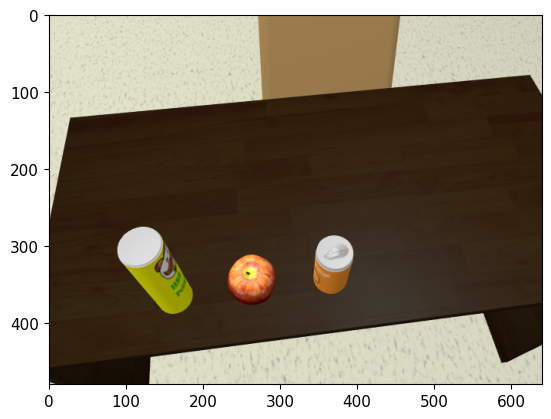

In [28]:
test_img = rgbd.get_image()
print(type(test_img))
plt.imshow(test_img)

In [ ]:
import rospkg
import os
import matplotlib.image as mpimg

rpg = rospkg.RosPack()
package_path = rpg.get_path('vision_modules')
img_path = os.path.join(package_path, "scripts")

img = mpimg.imread(img_path + '/20240223_171508.jpg')
plt.imshow(img)

In [8]:
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import *
from yolov5.utils.torch_utils import select_device

from cv_bridge import CvBridge
from object_classification.srv import Classify,ClassifyResponse, ClassifyRequest
import torch

device = select_device('')

file_path = rpg.get_path('object_classification')
ycb_yolo_path=file_path+'/src/weights/ycb.pt'
print(ycb_yolo_path)
model=attempt_load(ycb_yolo_path,device)


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)



/home/devan/GIT/Juskeshino/catkin_ws/src/vision/object_classification/src/weights/ycb.pt


Fusing layers... 
Model summary: 369 layers, 21138024 parameters, 0 gradients, 49.1 GFLOPs


(480, 640, 3)
<class 'numpy.ndarray'>
[tensor([[8.89578e+01, 2.75725e+02, 1.86860e+02, 3.87920e+02, 8.94660e-01, 1.00000e+00],
        [2.32563e+02, 3.12359e+02, 2.91796e+02, 3.77076e+02, 8.13388e-01, 1.20000e+01],
        [3.43167e+02, 2.87235e+02, 3.94868e+02, 3.61917e+02, 7.93512e-01, 2.10000e+01],
        [3.43226e+02, 2.87216e+02, 3.94666e+02, 3.61907e+02, 6.66470e-01, 1.00000e+00],
        [2.32481e+02, 3.12379e+02, 2.92829e+02, 3.75971e+02, 5.45902e-01, 1.60000e+01],
        [8.90563e+01, 2.75105e+02, 1.87222e+02, 3.86640e+02, 2.86717e-01, 5.00000e+00]], device='cuda:0')]
torch.Size([6, 6])


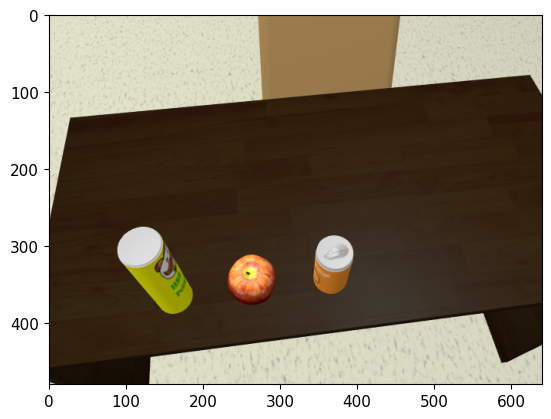

In [83]:
sampling_img = test_img
print(sampling_img.shape)
sample = torch.from_numpy(sampling_img).to(device)
sample = sample / 255.0
sample = sample.unsqueeze(0)
sample = torch.moveaxis(sample, 3, 1)
pred = model(sample, augment=False)[0]

plt.imshow(sampling_img)
print(type(sampling_img))

detections = non_max_suppression(pred)  # IOU 
print(detections)
print(detections[0].shape)

In [31]:
#cv2.imwrite("simulation.png", test_img)


True

In [84]:
def calc_IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	print("IOU of", boxA, boxB)
	
    # xA = max(boxA[0], boxB[0])
	# yA = max(boxA[1], boxB[1])
	# xB = min(boxA[2], boxB[2])
	# yB = min(boxA[3], boxB[3])
	xA = max(boxA[0][0], boxB[0][0])
	yA = max(boxA[0][1], boxB[0][1])
	xB = min(boxA[1][0], boxB[1][0])
	yB = min(boxA[1][1], boxB[1][1])
    
	
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	
	# boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	# boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	boxAArea = (boxA[1][0] - boxA[0][0] + 1) * (boxA[1][1] - boxA[0][1] + 1)
	boxBArea = (boxB[1][0] - boxB[0][0] + 1) * (boxB[1][1] - boxB[0][1] + 1)


	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou




#0.2857142857142857
#calc_IOU(((0,1),(2,3)), ((1,2),(3,4)))

1 (88, 275) (186, 387) 0.8946599364280701 002_master_chef_can
2 (232, 312) (291, 377) 0.8133879899978638 013_apple
3 (343, 287) (394, 361) 0.7935118079185486 021_bleach_cleanser
4 (343, 287) (394, 361) 0.6664696931838989 002_master_chef_can
5 (232, 312) (292, 375) 0.5459022521972656 017_orange


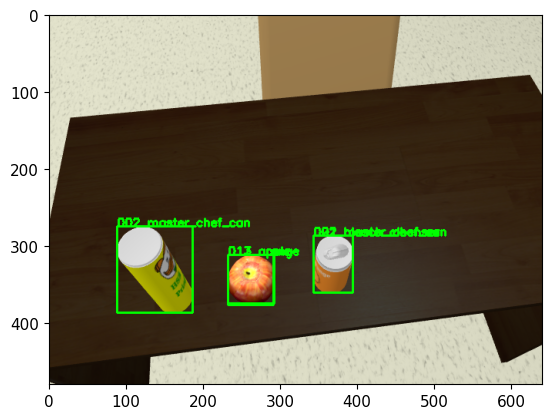

In [85]:
debug_img = sampling_img.copy()

num_preds = 0
points = []
labels = []
confidence_threshold = 0.4

for detect in detections:
    for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
        if conf.cpu().tolist() > confidence_threshold:
            num_preds+=1
            pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
            pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

            points.append((pt_min, pt_max))
            labels.append([round(conf.cpu().tolist(), 3), model.names[int(cls.cpu().tolist())]])

            debug_img = cv2.rectangle(debug_img ,pt_min,pt_max,  (0, 255, 0), 2)
            debug_img = cv2.putText(debug_img, model.names[int(cls.cpu().tolist())],
                        pt_min, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(num_preds, pt_min, pt_max, conf.cpu().tolist(), model.names[int(cls.cpu().tolist())] )
    
plt.imshow(debug_img)

In [80]:
print(points)
true_points = []
true_predictions = []



[((88, 275), (186, 387)), ((232, 312), (291, 377)), ((343, 287), (394, 361)), ((343, 287), (394, 361)), ((232, 312), (292, 375))]


In [86]:
for i, point in enumerate(true_points):
    print(point, " pred\t", true_predictions[i][0], true_predictions[i][1])

[((0, 0), (100, 100)), ((0, 0), (50, 50)), ((10, 10), (90, 90))]
[((10, 10), (90, 90)), ((0, 0), (50, 50)), ((0, 0), (100, 100))]
[[  0   0]
 [100 100]]

[[ 0  0]
 [50 50]]

[[10 10]
 [90 90]]



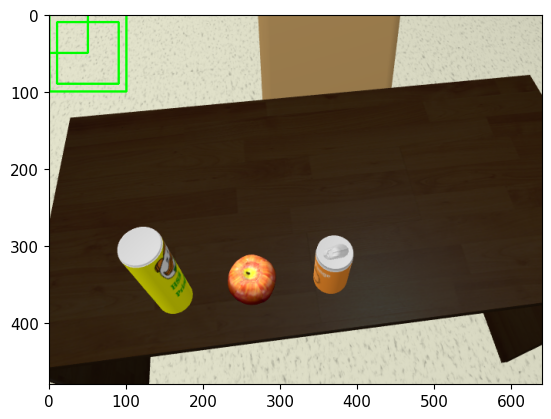

In [87]:
clone_img = sampling_img.copy()

points = []
points.append(((0,0), (100,100)))
points.append(((0,0), (50,50)))
points.append(((10,10), (90,90)))
print(points)

clear_points = points.copy()
clear_points.reverse()
print(clear_points)

for point in points:
    point_a = np.array(point)
    print(point_a)


    
    print()
    clone_img = cv2.rectangle(clone_img , point[0], point[1],  (0, 255, 0), 2)


plt.imshow(clone_img)

# ----------------------------

In [ ]:
debug_img = sampling_img.copy()

num_preds = 0
points = []
confidence_threshold = 0.4

for detect in detections:
    for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
        if conf.cpu().tolist() > confidence_threshold:
            num_preds+=1
            pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
            pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

            points.append((pt_min, pt_max))

            debug_img = cv2.rectangle(debug_img ,pt_min,pt_max,  (0, 255, 0), 2)
            debug_img = cv2.putText(debug_img, model.names[int(cls.cpu().tolist())],
                        pt_min, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(num_preds, pt_min, pt_max, conf.cpu().tolist(), model.names[int(cls.cpu().tolist())] )
    
plt.imshow(debug_img)